# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import glob
import os
import re

from joblib import Parallel, delayed
import kmermaid_utils
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import sig_utils
import sourmash
from tqdm import tqdm

pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 50

from sourmash_search_utils import read_and_process_sourmash_search_results

## Constants (ksizes, scaled)

In [4]:
ls -lha /home/olga/data_sm/immune-evolution/kmer-signatures

total 12K
drwxr-xr-x  8 olga czb 4.0K Mar  3 14:22 ./
drwxrwxr-x 81 olga czb 8.0K Feb 28 09:02 ../
drwxr-xr-x  4 olga czb 4.0K Feb 28 09:53 0--mouse2mouse/
drwxr-xr-x  7 olga czb 4.0K Feb 28 16:57 1--train-mouse/
drwxr-xr-x  8 olga czb 4.0K Mar  3 14:50 2--test-human/
drwxr-xr-x  7 olga czb 4.0K Mar  3 14:45 2--test-lemur/
drwxr-xr-x  7 olga czb 4.0K Feb 28 20:01 3--test-bat/
drwxr-xr-x  5 olga czb 4.0K Feb 28 19:48 4--test-lemur/


In [6]:
sig_outdir_base = '/home/olga/data_sm/immune-evolution/kmer-signatures'

bat_test_dir = os.path.join(sig_outdir_base, "3--test-bat")

aggregated_results_dir = os.path.join(bat_test_dir, '4--aggregated-results')
! mkdir -p $aggregated_results_dir

In [7]:
SHARED_CELLTYPES = set(['Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell'])
SHARED_CELLTYPES

{'Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell'}

## Def describe

In [10]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

### Remove rogue TQDM instances

In [11]:
def remove_rogue_tqdm():
    import tqdm
    try:
        tqdm._instances.clear()
    except AttributeError:
        pass

## Read one2one 5had

In [12]:
one2one = sc.read(
#     "/home/phoenix/data_sm/code/immune-evolution/h5ads/human-lemur-mouse-bat__lung_only_copy.h5ad"
    "/home/olga/data_sm/immune-evolution/h5ads/human-lemur-mouse-bat/human-lemur-mouse-bat__lung_only.h5ad"
)
one2one.obs = one2one.obs.reset_index().set_index('cell_id')

one2one.obs.head()

,index,age,cell_barcode,cell_ontology_class,cell_ontology_id,channel,free_annotation,individual,sample,sequencing_run,sex,species,species_batch,species_latin,tissue,narrow_group,broad_group,compartment_group,compartment_narrow,channel_cleaned,batch,n_genes,n_counts,species_batch_v2,compartment_broad,compartment_broad_narrow,compartment_species,compartment_narrow_species,common_individual_id
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P2_1__AAACCTGAGAAACCAT,P2_1_AAACCTGAGAAACCAT-human-hlm,46y,AAACCTGAGAAACCAT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AAATGCCAGATGAGAG,P2_1_AAATGCCAGATGAGAG-human-hlm,46y,AAATGCCAGATGAGAG,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGATCCCT,P2_1_AACACGTTCGATCCCT-human-hlm,46y,AACACGTTCGATCCCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGCACTCT,P2_1_AACACGTTCGCACTCT-human-hlm,46y,AACACGTTCGCACTCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACCATGCAGCTCGCA,P2_1_AACCATGCAGCTCGCA-human-hlm,46y,AACCATGCAGCTCGCA,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,male,Human,human,Homo sapiens,Lung,Capillary Aerocyte,Capillary,endothelial,endothelial: Capillary Aerocyte,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2


# Analyze Sourmash search

## Functions / tools to add cell type ontologies

## Search directory output

### Column renamer

In [13]:
cols = ["cell_ontology_class", "narrow_group", "broad_group", "compartment_group"]

mouse_renamer = {col: f"mouse_{col}"  for col in cols}
bat_renamer = {col: f"bat_{col}" for col in cols}

## Read output CSVs -- Parallelized

In [11]:
# from sourmash_search_utils import read_and_process_sourmash_search_results


# bat_kmermaid_base = (
#     "/home/olga/data_sm/immune-evolution/pipeline-results/bat/kmermaid/ksize_8"
# )
# bat_search_dir = os.path.join(
#     bat_kmermaid_base,
#     "search_bat_in_mouse_no_ribosome_no_containment_no_dissociation__per_celltype_remove_common_hashes__remove_refseq_ribosomal",
# #     "search_bat_in_mouse_no_ribosome_no_containment_no_dissociation__per_celltype_remove_common_hashes",
# )

# total = 612648

# globber = os.path.join(bat_search_dir, "alphabet-dayhoff__ksize-39__scaled-10", "*.csv")

# # dfs = Parallel(n_jobs=96)(
# #     delayed(read_and_process_sourmash_search_results)(
# #         csv, adata=one2one, column_renamer=bat_renamer, query_species='bat'
# #     )
# #     for csv in tqdm(glob.iglob(globber), total=total)
# # )

# # search_results = pd.concat(dfs, ignore_index=True)
# # print(search_results.shape)
# # search_results.head()

In [19]:
from sourmash_search_utils import add_ontologies

## Read output CSVs

In [103]:
bat_test_dir

'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat'

In [115]:


globber = os.path.join(bat_test_dir, "3-*", "*", "*.csv")

total = sum(1 for _ in glob.iglob(globber))
total

216998

In [116]:
dna_count = sum(1 for x in glob.iglob(globber) if "DNA" in x)
dna_count

62208

In [117]:

dfs = []

celltype_col = "broad_group"
query_species = "bat"
query_cell_id_col = f"{query_species}_cell_id"
query_celltype_col = f"{query_species}_{celltype_col}"

sbt_species = "mouse"
sbt_celltype_col = f"{sbt_species}_{celltype_col}"


for csv in tqdm(glob.iglob(globber), total=total):
    df = read_and_process_sourmash_search_results(
        csv,
        adata=one2one,
        column_renamer=bat_renamer,
        query_species="bat",
        shared_celltypes=SHARED_CELLTYPES,
    )

    df["database_type"] = os.path.dirname(csv).split("/")[-2].split("--")[-1]

    dfs.append(df)
# break
search_results = pd.concat(dfs, ignore_index=True)
print(search_results.shape)
search_results.head()

100%|██████████| 216998/216998 [3:20:11<00:00, 18.07it/s]   


(2169496, 16)


,similarity,mouse_broad_group,search_method,sketch_id,bat_cell_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,database_type
0,0.098667,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
1,0.090870,Monocyte,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
2,0.086759,Alveolar Epithelial Type 2,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
3,0.085909,Smooth Muscle and Myofibroblast,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
4,0.081798,Fibroblast,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers


In [118]:
globber = os.path.join(bat_test_dir, "3-*", "*", "*.csv")

total = sum(1 for _ in glob.iglob(globber))

In [119]:
search_results.sketch_id.value_counts()

alphabet-protein__ksize-30__scaled-10    777329
alphabet-dayhoff__ksize-51__scaled-10    770087
alphabet-DNA__ksize-21__scaled-10        622080
Name: sketch_id, dtype: int64

In [120]:
csv

'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/3-1--mouse-search-results--min-10-percent-shared-kmers/alphabet-protein__ksize-30__scaled-10/bat3-LU__TTGGCAATCGGAAATA.csv'

In [121]:
dna_csv = '/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/3-3--mouse-search-results--min-10-percent-shared-kmers-remove-common-kmers/alphabet-dayhoff__ksize-51__scaled-10/bat2-LU__AAACCTGAGGTACTCT.csv'


In [122]:
dna_csv

'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/3-3--mouse-search-results--min-10-percent-shared-kmers-remove-common-kmers/alphabet-dayhoff__ksize-51__scaled-10/bat2-LU__AAACCTGAGGTACTCT.csv'

In [123]:
csv

'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/3-1--mouse-search-results--min-10-percent-shared-kmers/alphabet-protein__ksize-30__scaled-10/bat3-LU__TTGGCAATCGGAAATA.csv'

In [124]:
total

216998

In [125]:
search_results.search_method.value_counts()

similarity_abundance    1239296
containment              930200
Name: search_method, dtype: int64

In [126]:
search_results.sketch_id.value_counts()

alphabet-protein__ksize-30__scaled-10    777329
alphabet-dayhoff__ksize-51__scaled-10    770087
alphabet-DNA__ksize-21__scaled-10        622080
Name: sketch_id, dtype: int64

In [127]:
describe(search_results)

(2169496, 16)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,bat_cell_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,database_type
0,0.098667,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
1,0.090870,Monocyte,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
2,0.086759,Alveolar Epithelial Type 2,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
3,0.085909,Smooth Muscle and Myofibroblast,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers
4,0.081798,Fibroblast,containment,alphabet-dayhoff__ksize-51__scaled-10,bat3-LU__AGTGAGGCAGGATCGA,alphabet,dayhoff,51,scaled,10,bat3-LU,nan,Alveolar Fibroblast,Fibroblast,stromal,min-5-percent-shared-kmers


In [128]:
n_results_per_sketch_id = search_results.groupby(['sketch_id', 'alphabet', 'ksize']).size()
n_results_per_sketch_id.name = 'n_results'
n_results_per_sketch_id = n_results_per_sketch_id.reset_index()
describe(n_results_per_sketch_id)

(3, 4)
--- First 5 entries ---


,sketch_id,alphabet,ksize,n_results
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,622080
1,alphabet-dayhoff__ksize-51__scaled-10,dayhoff,51,770087
2,alphabet-protein__ksize-30__scaled-10,protein,30,777329


In [129]:
n_results_per_sketch_id.nlargest(5, 'n_results')

,sketch_id,alphabet,ksize,n_results
2,alphabet-protein__ksize-30__scaled-10,protein,30,777329
1,alphabet-dayhoff__ksize-51__scaled-10,dayhoff,51,770087
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,622080


In [130]:
n_results_per_sketch_id.loc[n_results_per_sketch_id.n_results.argmax()]

sketch_id    alphabet-protein__ksize-30__scaled-10
alphabet                                   protein
ksize                                           30
n_results                                   777329
Name: 2, dtype: object

## Constants (`classification_groupby`, `celltype_col`, `query_organism`, `scoring_groupby`)

In [131]:
celltype_col = "broad_group"
sbt_organism = "mouse"
query_organism = "bat"

classification_groupby = [
    f"{query_organism}_cell_id",
    "database_type",
    "search_method",
    "alphabet",
    "ksize",
]

predicted_celltype_col = f"{sbt_organism}_{celltype_col}"
ground_truth_celltype_col = f"{query_organism}_{celltype_col}"

scoring_groupby = ["database_type", "search_method", "alphabet", "ksize"]

## Add unifying column of predicted and ground truth celltypes

In [132]:
search_results['groundtruth_celltype'] = search_results[ground_truth_celltype_col]
search_results['predicted_celltype'] = search_results[predicted_celltype_col]

# write results to parquet file

In [133]:
%%time

parquet_fn = "sourmash-search-results.parquet"
parquet = os.path.join(aggregated_results_dir, parquet_fn)
search_results.to_parquet(parquet)

parquet

CPU times: user 3.48 s, sys: 540 ms, total: 4.02 s
Wall time: 4.09 s


'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/4--aggregated-results/sourmash-search-results.parquet'

# Predict cell type with top hit

## Get top N

In [134]:
%%time

predicted_cells_top_hit = search_results.groupby(
    classification_groupby, as_index=False, group_keys=False
).apply(lambda x: x.nlargest(1, 'similarity'))

predicted_cells_top_hit = predicted_cells_top_hit.set_index(f"{query_organism}_cell_id")

print(predicted_cells_top_hit.shape)
predicted_cells_top_hit.head()

(216998, 17)
CPU times: user 16min 48s, sys: 39.9 s, total: 17min 28s
Wall time: 17min 20s


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,database_type,groundtruth_celltype,predicted_celltype
bat_cell_id,,,,,,,,,,,,,,,,,
bat2-LU__AAACCTGAGGTACTCT,0.021308,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.056749,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.064116,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.060978,Macrophage,similarity_abundance,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
bat2-LU__AAACCTGAGGTACTCT,0.030150,Dendritic,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic


## Add unifying column of predicted and ground truth celltypes

In [135]:
predicted_cells_top_hit['groundtruth_celltype'] = predicted_cells_top_hit[ground_truth_celltype_col]
predicted_cells_top_hit['predicted_celltype'] = predicted_cells_top_hit[predicted_celltype_col]

### Write top N to file

In [136]:
%%time

parquet_fn = "sourmash-search-results--top-hit.parquet"
parquet = os.path.join(aggregated_results_dir, parquet_fn)
predicted_cells_top_hit.to_parquet(parquet)

CPU times: user 886 ms, sys: 52 ms, total: 938 ms
Wall time: 1.01 s


In [137]:
parquet

'/home/olga/data_sm/immune-evolution/kmer-signatures/3--test-bat/4--aggregated-results/sourmash-search-results--top-hit.parquet'

# Get ideal ksizes per alphabet sizes

In [74]:
alphabet_sizes = pd.Series(dict(dayhoff=6, protein=20))  # hp=2,
np.log10(alphabet_sizes.pow(21 / 3))

dayhoff    5.447059
protein    9.107210
dtype: float64

In [75]:
ideal_ksizes = np.ceil(21 * np.log(4) / np.log(alphabet_sizes))
ideal_ksizes

dayhoff    17.0
protein    10.0
dtype: float64

In [76]:
np.log10(alphabet_sizes.pow(ideal_ksizes))

dayhoff    13.228571
protein    13.010300
dtype: float64

In [77]:
k_nuc_sizes = np.arange(21, 91, 3)
k_nuc_sizes

array([21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69,
       72, 75, 78, 81, 84, 87, 90])

In [78]:
k_aa_sizes = k_nuc_sizes/3
k_aa_sizes

array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [79]:
dna_entropy = pd.Series(k_nuc_sizes * np.log10(4), name='entropy', index=k_nuc_sizes)
dna_entropy = dna_entropy.reset_index()
dna_entropy = dna_entropy.rename(columns={'index': 'k_nuc'})
dna_entropy['alphabet'] = 'dna'
describe(dna_entropy)

(24, 3)
--- First 5 entries ---


,k_nuc,entropy,alphabet
0,21,12.64326,dna
1,24,14.44944,dna
2,27,16.25562,dna
3,30,18.06180,dna
4,33,19.86798,dna


In [80]:
aa_nuc_alphabet_sizes = alphabet_sizes.copy()
aa_nuc_alphabet_sizes['dna'] = 4

In [81]:
alphabet_complexity = alphabet_sizes.to_frame().apply(
    lambda x: pd.Series(k_aa_sizes * np.log10(x.iloc[0]), name=x.name), axis=1
)
alphabet_complexity.columns = k_nuc_sizes
alphabet_complexity = alphabet_complexity.unstack().reset_index()
alphabet_complexity = alphabet_complexity.rename(
    columns={"level_0": "k_nuc", "level_1": "alphabet", 0: "entropy"}
)
alphabet_complexity = pd.concat([alphabet_complexity, dna_entropy])
alphabet_complexity["k_aa"] = (alphabet_complexity["k_nuc"] / 3).astype(int)
alphabet_complexity["sigma"] = alphabet_complexity.alphabet.map(aa_nuc_alphabet_sizes)
alphabet_complexity["alphabet_type"] = alphabet_complexity.alphabet.map(
    lambda x: "nuc" if x == "dna" else "aa"
)
alphabet_complexity["alphabet_label"] = alphabet_complexity.apply(
    lambda x: "{alphabet} $|\Sigma_{{{alphabet_type}}}| = {sigma}$".format(**x), axis=1
)
describe(alphabet_complexity)

(72, 7)
--- First 5 entries ---


,k_nuc,alphabet,entropy,k_aa,sigma,alphabet_type,alphabet_label
0,21,dayhoff,5.447059,7,6,aa,dayhoff $|\Sigma_{aa}| = 6$
1,21,protein,9.107210,7,20,aa,protein $|\Sigma_{aa}| = 20$
2,24,dayhoff,6.225210,8,6,aa,dayhoff $|\Sigma_{aa}| = 6$
3,24,protein,10.408240,8,20,aa,protein $|\Sigma_{aa}| = 20$
4,27,dayhoff,7.003361,9,6,aa,dayhoff $|\Sigma_{aa}| = 6$


In [82]:
sorted(alphabet_complexity.alphabet_label.unique())

['dayhoff $|\\Sigma_{aa}| = 6$',
 'dna $|\\Sigma_{nuc}| = 4$',
 'protein $|\\Sigma_{aa}| = 20$']

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


IndexError: single positional indexer is out-of-bounds

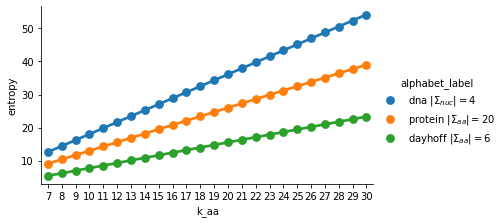

In [83]:
alphabet_order = [
    "dna $|\\Sigma_{nuc}| = 4$",
    "protein $|\\Sigma_{aa}| = 20$",
    "dayhoff $|\\Sigma_{aa}| = 6$",
#     "hp $|\\Sigma_{aa}| = 2$",
]

g = sns.catplot(
    x="k_aa",
    data=alphabet_complexity,
    y="entropy",
    hue="alphabet_label",
    kind="point",
    size=3,
    aspect=1.75,
    hue_order=alphabet_order,
)

entropy_min = alphabet_complexity.query(
    'k_nuc == 63 and alphabet == "hp"'
).entropy.iloc[0]
entropy_max = alphabet_complexity.query(
    'k_nuc == 60 and alphabet == "dayhoff"'
).entropy.iloc[0]

for ax in g.axes.flat:
    xmin, xmax = ax.get_xlim()
    ax.fill_between(
        (xmin, xmax), entropy_min, entropy_max, color="lightgrey", zorder=-1
    )
    ax.axhline(entropy_min, color="grey", linestyle="--", zorder=-1)
    ax.axhline(entropy_max, color="grey", linestyle="--", zorder=-1)

g.set(
    ylabel=r"$k \times \log_{10} \left( | \Sigma | \right)$",
    xlim=(xmin, xmax),
    ylim=(0, 30),
    xlabel=r"$k_{aa}$ size",
)
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/analysis/alphabet_size_vs_complexity"
)
! mkdir -p $figure_folder
pdf = os.path.join(figure_folder, "alphabet_size_vs_complexity.pdf")
g.savefig(pdf)

In [ ]:
alphabet_complexity.query('k_nuc == 39')

In [ ]:
alphabet_complexity.query('k_nuc == 51')

In [ ]:
alphabet_complexity.query()